In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gpplot
import sglearn
import shap
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score

from datasets import behan_data, aguirre_data
from core import add_xy_line, setup_plots

In [2]:
setup_plots()

In [3]:
behan_data.load_data()
aguirre_data.load_data()

merged_activity = (behan_data.get_sg_df(include_group=True, include_activity=True)
                   .rename({'sgRNA Activity': 'Behan Activity'}, axis=1)
                   .merge(aguirre_data.get_sg_df(include_group=True, include_activity=True)
                          .rename({'sgRNA Activity': 'Aguirre Activity'}, axis=1),
                          how='inner', on=['sgRNA Sequence', 'sgRNA Context Sequence',
                                           'PAM Sequence', 'sgRNA Target']))
merged_activity['Behan Activity'] = ((merged_activity['Behan Activity'] - merged_activity['Behan Activity'].mean())/
                                     merged_activity['Behan Activity'].std())
merged_activity['Aguirre Activity'] = ((merged_activity['Aguirre Activity'] - merged_activity['Aguirre Activity'].mean())/
                                       merged_activity['Aguirre Activity'].std())
merged_activity['Activity Difference'] = merged_activity['Aguirre Activity'] - merged_activity['Behan Activity']

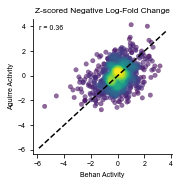

In [4]:
plt.subplots(figsize=(2.5, 2.5))
gpplot.point_densityplot(merged_activity, x='Behan Activity',
                         y='Aguirre Activity', s=20)
gpplot.add_correlation(merged_activity, x='Behan Activity',
                       y='Aguirre Activity')
add_xy_line()
sns.despine()
plt.title('Z-scored Negative Log-Fold Change')
gpplot.savefig('../figures/aguirre_behan_comparison.pdf', dpi=300)

In [5]:
X = sglearn.featurize_guides(merged_activity['sgRNA Context Sequence'])
y = merged_activity['Activity Difference']
cv_score = cross_val_score(LGBMRegressor(random_state=7), X, y, cv=5, n_jobs=5,
                      scoring='r2')
print(cv_score)
print(cv_score.mean())

[0.08147215 0.04450659 0.12169665 0.03568002 0.08920977]
0.07451303697482595


In [6]:
model = LGBMRegressor(random_state=7, n_jobs=8)
model.fit(X, y)

LGBMRegressor(n_jobs=8, random_state=7)

In [7]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

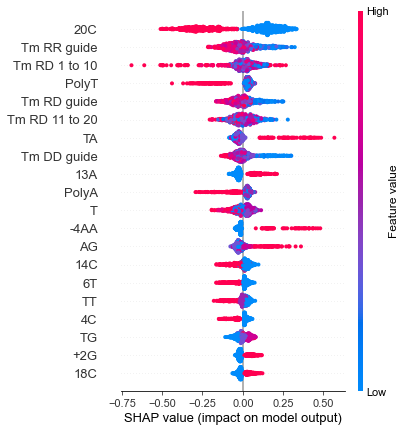

In [8]:
shap.summary_plot(shap_values, X, show=False, plot_size=(5, 7))
gpplot.savefig('../figures/aguirre_behan_difference_model_importance.pdf',
               dpi=300)

In [9]:
merged_activity_features = (merged_activity
                            .merge(X.reset_index()
                                   .rename({0: 'sgRNA Context Sequence'}, axis=1),
                                   how='inner',
                                   on='sgRNA Context Sequence'))

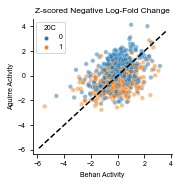

In [10]:
plt.subplots(figsize=(2.5, 2.5))
sns.scatterplot(data=merged_activity_features, x='Behan Activity',
                y='Aguirre Activity', hue='20C', alpha=0.5, s=20)
add_xy_line()
sns.despine()
plt.title('Z-scored Negative Log-Fold Change')
plt.legend(markerscale=0.5, title='20C')
gpplot.savefig('../figures/aguirre_behan_comparison_20C.pdf', dpi=300)

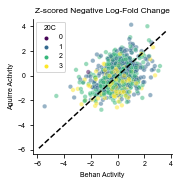

In [11]:
plt.subplots(figsize=(2.5, 2.5))
sns.scatterplot(data=merged_activity_features, x='Behan Activity',
                y='Aguirre Activity', hue='PolyT', alpha=0.5, s=20,
                palette='viridis')
add_xy_line()
sns.despine()
plt.title('Z-scored Negative Log-Fold Change')
plt.legend(markerscale=0.5, title='20C')